In [1]:
# %pip install -r /home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/model/CelebV2/requirements.txt

# # Step 1: Uninstall incompatible NumPy version
# %pip uninstall numpy -y
# # Step 2: Install compatible NumPy version (< 2.0.0)
# %pip install "numpy>=1.21.0,<2.0.0"
# # Step 3: Verify NumPy version
# import numpy as np
# print(f"✅ NumPy version: {np.__version__}")
# print(f"Expected: < 2.0.0 (you should see 1.x.x)")

In [2]:
# Built-in
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

2025-10-13 23:07:01.706774: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 23:07:01.795858: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-13 23:07:02.166445: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-13 23:07:02.166555: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-13 23:07:02.169516: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
# Define the path to the dataset
base_path = '/home/huuquangdang/huu.quang.dang/thesis/Dataset/celeb_df_crop'
categories = ['fake', 'real']

# Initialize a list to hold data
data = []

# Process each category
for category in categories:
    category_path = os.path.join(base_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            try:
                id_part, frame_part = filename.split('_frame_')
                id_ = id_part.split('_')[0]
                frame = frame_part.split('.')[0]
                data.append({
                    'filename': filename,
                    'path': os.path.join(category_path, filename),
                    'id': int(id_),
                    'frame': int(frame),
                    'label': category
                })
            except ValueError:
                continue

# Convert the data to a DataFrame
df = pd.DataFrame(data)

In [4]:
# Đảm bảo đã có df_cropped.csv chứa đường dẫn ảnh đã crop
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})
df


,filename,path,id,frame,label,label_id
0,264_id37_0009_frame_0001.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,264,1,fake,0
1,271_id38_0006_frame_0014.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,271,14,fake,0
2,015_id10_0006_frame_0027.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,15,27,fake,0
3,392_id4_0007_frame_0028.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,392,28,fake,0
4,029_id11_0010_frame_0004.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,29,4,fake,0
...,...,...,...,...,...,...
32367,475_id58_0004_frame_0012.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,475,12,real,1
32368,014_id10_0005_frame_0012.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,14,12,real,1
32369,365_id48_0000_frame_0023.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,365,23,real,1
32370,091_id20_0000_frame_0026.jpg,/home/huuquangdang/huu.quang.dang/thesis/Datas...,91,26,real,1


In [5]:
df['video_key'] = df['id'].astype(str) + "_" + df['label']

from collections import defaultdict

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']


In [6]:
# !pip install opencv-python

In [7]:
# Load pre-extracted CSV features for feature fusion
print("📂 Loading pre-extracted OpenFace features from CSV files...")
csv_fake_path = '/home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/tools/fake/op_vectors_fake_v1.csv'
csv_real_path = '/home/huuquangdang/huu.quang.dang/thesis/deepfake/deepfake_backend/libs/tools/real/op_vectors_real_v1.csv'

df_fake_features = pd.read_csv(csv_fake_path, header=None)
df_real_features = pd.read_csv(csv_real_path, header=None)

# Combine both dataframes
df_all_features = pd.concat([df_fake_features, df_real_features], ignore_index=True)
df_all_features.columns = ['filename'] + [f'feat_{i}' for i in range(df_all_features.shape[1] - 1)]

# Create a dictionary for fast lookup: filename -> features
openface_features = {}
for _, row in df_all_features.iterrows():
    filename = row['filename']
    features = row.iloc[1:].values.astype('float32')
    openface_features[filename] = features

csv_feature_dim = len(features)
print(f"✅ Loaded {len(openface_features)} feature vectors")
print(f"✅ Each vector has {csv_feature_dim} dimensions")
print(f"✅ Feature dictionary ready for 1-to-1 frame mapping")

📂 Loading pre-extracted OpenFace features from CSV files...
✅ Loaded 16223 feature vectors
✅ Each vector has 674 dimensions
✅ Feature dictionary ready for 1-to-1 frame mapping


In [8]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dropout, Dense, GlobalAveragePooling2D, Concatenate, LayerNormalization, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from hmmlearn.hmm import GaussianHMM
from tfkan.layers import Conv2DKAN, DenseKAN
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler

# Configuration
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 32
epochs = 50
n_splits = 5
sequence_len = 10
results = []
all_histories = []

# 🔧 FIX 1: Normalize CSV features (they have different scales than MobileNet)
print("🔧 Computing CSV feature statistics for normalization...")
all_csv_features = []
for key in video_keys:
    frames = video_dict[key][:sequence_len]
    for path in frames:
        filename = os.path.basename(path)
        if filename in openface_features:
            all_csv_features.append(openface_features[filename])

csv_scaler = StandardScaler()
csv_scaler.fit(all_csv_features)
print(f"✅ CSV feature normalization fitted on {len(all_csv_features)} samples")

# Enhanced Data generator with normalized CSV features
class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=10, augment=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15 if augment else 0,
            zoom_range=0.1 if augment else 0,
            horizontal_flip=augment
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X_img, batch_X_csv, batch_y = [], [], []

        for key in batch_keys:
            frames = self.video_dict[key][:self.sequence_len]
            imgs = []
            csv_feats = []
            
            for path in frames:
                # Load and process image
                img = cv2.imread(path)
                img = cv2.resize(img, self.img_size)
                img = self.datagen.random_transform(img) if self.augment else img
                img = img.astype('float32') / 255.0
                imgs.append(img)
                
                # Load CSV features and NORMALIZE (FIX: scale matching)
                filename = os.path.basename(path)
                if filename in openface_features:
                    csv_feat = openface_features[filename]
                    csv_feat = csv_scaler.transform([csv_feat])[0]  # Normalize
                else:
                    csv_feat = np.zeros(csv_feature_dim, dtype='float32')
                csv_feats.append(csv_feat)
            
            # Pad sequences if needed
            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))
                csv_feats.append(np.zeros(csv_feature_dim, dtype='float32'))
            
            batch_X_img.append(imgs)
            batch_X_csv.append(csv_feats)
            batch_y.append(self.labels[key])

        return [np.array(batch_X_img), np.array(batch_X_csv)], np.array(batch_y)

# 🔧 FIX 2: Improved model architecture
def build_model(sequence_len, img_size, csv_dim=674):
    # MobileNet branch
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    
    # 🔧 FIX: Unfreeze last few layers of MobileNet for fine-tuning
    base_cnn.trainable = True
    for layer in base_cnn.layers[:-20]:  # Freeze all except last 20 layers
        layer.trainable = False
    
    cnn_out = GlobalAveragePooling2D()(base_cnn.output)
    cnn_model = Model(inputs=base_cnn.input, outputs=cnn_out)
    
    # Image sequence input
    input_seq_img = Input(shape=(sequence_len, *img_size, 3), name='image_input')
    x_img = TimeDistributed(cnn_model)(input_seq_img)
    
    # CSV features input
    input_seq_csv = Input(shape=(sequence_len, csv_dim), name='csv_input')
    
    # 🔧 FIX: Add BatchNormalization before concatenation
    x_img = BatchNormalization()(x_img)
    x_csv = BatchNormalization()(input_seq_csv)
    
    # Concatenate features
    x_combined = Concatenate(axis=-1)([x_img, x_csv])
    
    # 🔧 FIX: Larger LSTM and less aggressive dropout
    x = LSTM(128, return_sequences=True)(x_combined)  # Increased from 64 to 128
    x = Dropout(0.3)(x)  # Reduced from 0.5 to 0.3
    x = LSTM(64, return_sequences=False)(x)  # Add second LSTM layer
    x = Dropout(0.3)(x)
    
    # Classification
    x = Dense(32, activation='relu')(x)  # Add dense layer before KAN
    x = Dropout(0.2)(x)
    x = DenseKAN(1)(x)
    output = tf.keras.activations.sigmoid(x)
    
    model = Model(inputs=[input_seq_img, input_seq_csv], outputs=output)
    return model

# HMM post-processing (unchanged)
def hmm_postprocess(pred_probs, y_true, n_states=2):
    pred_probs = pred_probs.reshape(-1, 1)
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    hmm.fit(pred_probs)
    hidden_states = hmm.predict(pred_probs)

    mapping = {}
    for state in np.unique(hidden_states):
        indices = [i for i in range(len(hidden_states)) if hidden_states[i] == state]
        state_labels = [y_true[i] for i in indices]
        if len(state_labels) > 0:
            mapped_label = mode(state_labels, keepdims=True).mode[0]
        else:
            mapped_label = 0
        mapping[state] = mapped_label

    hmm_labels = np.array([mapping[s] for s in hidden_states])
    return hmm_labels

# Training K-Fold with improvements
print("\n🚀 Starting IMPROVED K-Fold training with:")
print("   ✅ Normalized CSV features")
print("   ✅ Partially unfrozen MobileNet (last 20 layers)")
print("   ✅ Larger LSTM (128→64 units)")
print("   ✅ Lower dropout (0.3 instead of 0.5)")
print("   ✅ BatchNormalization layers")
print("   ✅ Additional Dense layer\n")

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n{'='*60}")
    print(f"📊 Fold {fold}/{n_splits}")
    print(f"{'='*60}")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(trainval_keys, test_size=0.1, stratify=y_trainval, random_state=fold)

    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=True)
    val_gen = VideoSequence(val_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)
    test_gen = VideoSequence(test_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)

    model = build_model(sequence_len, img_size, csv_feature_dim)
    
    # 🔧 FIX: Higher learning rate for better convergence
    model.compile(optimizer=Adamax(3e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    print(f"\n📈 Model Summary:")
    print(f"   - Total params: {model.count_params():,}")
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"   - Trainable params: {trainable_params:,}")
    print(f"   - MobileNet: Last 20 layers trainable")
    print(f"   - LSTM: 128→64 units (stacked)")
    print(f"   - Learning rate: 3e-4")

    model_path = f"best_model_fold{fold}_improved.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,
                        callbacks=[checkpoint, earlystop, reduce_lr], verbose=1)
    all_histories.append(history.history)

    model.load_weights(model_path)

    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_hmm_pred = hmm_postprocess(y_pred_prob, y_true)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_hmm_pred),
        'precision': precision_score(y_true, y_hmm_pred),
        'recall': recall_score(y_true, y_hmm_pred),
        'f1': f1_score(y_true, y_hmm_pred),
        'auc': roc_auc_score(y_true, y_pred_prob)
    })
    
    print(f"\n✅ Fold {fold} Results:")
    print(f"   Accuracy:  {results[-1]['accuracy']:.4f}")
    print(f"   Precision: {results[-1]['precision']:.4f}")
    print(f"   Recall:    {results[-1]['recall']:.4f}")
    print(f"   F1 Score:  {results[-1]['f1']:.4f}")
    print(f"   AUC:       {results[-1]['auc']:.4f}")

print(f"\n{'='*60}")
print("📊 FINAL RESULTS - All Folds Summary")
print(f"{'='*60}")
for r in results:
    print(f"Fold {r['fold']}: Acc={r['accuracy']:.4f}, Prec={r['precision']:.4f}, Rec={r['recall']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")

🔧 Computing CSV feature statistics for normalization...
✅ CSV feature normalization fitted on 10840 samples

🚀 Starting IMPROVED K-Fold training with:
   ✅ Normalized CSV features
   ✅ Partially unfrozen MobileNet (last 20 layers)
   ✅ Larger LSTM (128→64 units)
   ✅ Lower dropout (0.3 instead of 0.5)
   ✅ BatchNormalization layers
   ✅ Additional Dense layer


📊 Fold 1/5

📈 Model Summary:
   - Total params: 3,384,457
   - Trainable params: 2,328,261
   - MobileNet: Last 20 layers trainable
   - LSTM: 128→64 units (stacked)
   - Learning rate: 3e-4
Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.6642 - accuracy: 0.6051
Epoch 1: val_accuracy improved from -inf to 0.49425, saving model to best_model_fold1_improved.h5
25/25 [==============================] - 93s 4s/step - loss: 0.6642 - accuracy: 0.6051 - val_loss: 0.6922 - val_accuracy: 0.4943 - lr: 3.0000e-04
Epoch 2/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.5553 - accuracy: 0.7885
Epoch 2: val_accuracy did not improve from 0.49425
25/25 [==============================] - 81s 3s/step - loss: 0.5553 - accuracy: 0.7885 - val_loss: 0.7913 - val_accuracy: 0.4943 - lr: 3.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.4288 - accuracy: 0.8526
Epoch 3: val_accuracy did not improve from 0.49425
25/25 [==============================] - 81s 3s/step - loss: 0.4288 - accuracy: 0.8526 - val_loss: 0.9788 - val_accuracy: 0.4943 - lr: 3.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.3127 - accuracy: 0.9128
Epoch 4: val_accuracy did not improve from 0.49425

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 79s 3s/step - loss: 0.3127 - accuracy: 0.9128 - val_loss: 1.2950 - val_accuracy: 0.4943 - lr: 3.0000e-04
Epoch 5/50
25/25 [==============================] - ETA: 0s -

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.9667
Epoch 7: val_accuracy did not improve from 0.50575

Epoch 7: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
25/25 [==============================] - 79s 3s/step - loss: 0.1479 - accuracy: 0.9667 - val_loss: 1.4951 - val_accuracy: 0.5057 - lr: 1.5000e-04
Epoch 8/50
25/25 [==============================] - ETA: 0s - loss: 0.1270 - accuracy: 0.9667
Epoch 8: val_accuracy did not improve from 0.50575
25/25 [==============================] - 80s 3s/step - loss: 0.1270 - accuracy: 0.9667 - val_loss: 1.5847 - val_accuracy: 0.5057 - lr: 7.5000e-05
Epoch 9/50
25/25 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 0.9667
Epoch 9: val_accuracy improved from 0.50575 to 0.51724, saving model to best_model_fold1_improved.h5
25/25 [==============================] - 80s 3s/step - loss: 0.1164 - accuracy: 0.9667 - val_loss: 1.6228 - val_accuracy: 0.5172 - lr: 7.5000e-05
Epoch 10/50

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1013 - accuracy: 0.9833
Epoch 10: val_accuracy did not improve from 0.51724

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
25/25 [==============================] - 79s 3s/step - loss: 0.1013 - accuracy: 0.9833 - val_loss: 1.6370 - val_accuracy: 0.5172 - lr: 7.5000e-05
Epoch 11/50
25/25 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.9808
Epoch 11: val_accuracy did not improve from 0.51724
25/25 [==============================] - 79s 3s/step - loss: 0.0914 - accuracy: 0.9808 - val_loss: 1.6651 - val_accuracy: 0.5172 - lr: 3.7500e-05
Epoch 12/50
25/25 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9885
Epoch 12: val_accuracy did not improve from 0.51724
25/25 [==============================] - 79s 3s/step - loss: 0.0795 - accuracy: 0.9885 - val_loss: 1.6900 - val_accuracy: 0.5172 - lr: 3.7500e-05
Epoch 13/50
25/25 [==============================] - E

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9859
Epoch 14: val_accuracy did not improve from 0.52874
25/25 [==============================] - 80s 3s/step - loss: 0.0738 - accuracy: 0.9859 - val_loss: 1.6615 - val_accuracy: 0.5287 - lr: 1.8750e-05
Epoch 15/50
25/25 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.9885
Epoch 15: val_accuracy did not improve from 0.52874
25/25 [==============================] - 80s 3s/step - loss: 0.0780 - accuracy: 0.9885 - val_loss: 1.6538 - val_accuracy: 0.5287 - lr: 1.8750e-05
Epoch 16/50
25/25 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.9923
Epoch 16: val_accuracy improved from 0.52874 to 0.55172, saving model to best_model_fold1_improved.h5

Epoch 16: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.
25/25 [==============================] - 80s 3s/step - loss: 0.0677 - accuracy: 0.9923 - val_loss: 1.6362 - val_accuracy: 0.5517 - lr: 1.8750e-05
Epoch

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0646 - accuracy: 0.9936
Epoch 17: val_accuracy improved from 0.55172 to 0.57471, saving model to best_model_fold1_improved.h5
25/25 [==============================] - 83s 3s/step - loss: 0.0646 - accuracy: 0.9936 - val_loss: 1.6151 - val_accuracy: 0.5747 - lr: 9.3750e-06
Epoch 18/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9897
Epoch 18: val_accuracy did not improve from 0.57471
25/25 [==============================] - 87s 3s/step - loss: 0.0684 - accuracy: 0.9897 - val_loss: 1.5944 - val_accuracy: 0.5747 - lr: 9.3750e-06
Epoch 19/50
25/25 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9910
Epoch 19: val_accuracy improved from 0.57471 to 0.58621, saving model to best_model_fold1_improved.h5

Epoch 19: ReduceLROnPlateau reducing learning rate to 4.687500222644303e-06.
25/25 [==============================] - 86s 3s/step - loss: 0.0651 - accuracy: 0.9910 - val_loss: 1.5761 - val_accuracy: 0.5862 - lr: 9.3750e-06
Epoch 20/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.9910
Epoch 20: val_accuracy did not improve from 0.58621
25/25 [==============================] - 85s 3s/step - loss: 0.0663 - accuracy: 0.9910 - val_loss: 1.5505 - val_accuracy: 0.5862 - lr: 4.6875e-06
Epoch 21/50
25/25 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9936
Epoch 21: val_accuracy did not improve from 0.58621
25/25 [==============================] - 85s 3s/step - loss: 0.0647 - accuracy: 0.9936 - val_loss: 1.5282 - val_accuracy: 0.5862 - lr: 4.6875e-06
Epoch 22/50
25/25 [==============================] - ETA: 0s - loss: 0.0658 - accuracy: 0.9910
Epoch 22: val_accuracy did not improve from 0.58621

Epoch 22: ReduceLROnPlateau reducing learning rate to 2.3437501113221515e-06.
25/25 [==============================] - 85s 3s/step - loss: 0.0658 - accuracy: 0.9910 - val_loss: 1.5012 - val_accuracy: 0.5862 - lr: 4.6875e-06
Epoch 23/50
25/25 [==============================] - E

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 25/50
25/25 [==============================] - ETA: 0s - loss: 0.0604 - accuracy: 0.9910
Epoch 25: val_accuracy did not improve from 0.60920

Epoch 25: ReduceLROnPlateau reducing learning rate to 1.1718750556610757e-06.
25/25 [==============================] - 125s 5s/step - loss: 0.0604 - accuracy: 0.9910 - val_loss: 1.4011 - val_accuracy: 0.6092 - lr: 2.3438e-06
Epoch 26/50
25/25 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.9859
Epoch 26: val_accuracy did not improve from 0.60920
25/25 [==============================] - 83s 3s/step - loss: 0.0696 - accuracy: 0.9859 - val_loss: 1.3627 - val_accuracy: 0.6092 - lr: 1.1719e-06
Epoch 27/50
25/25 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9897
Epoch 27: val_accuracy did not improve from 0.60920
25/25 [==============================] - 116s 5s/step - loss: 0.0616 - accuracy: 0.9897 - val_loss: 1.3233 - val_accuracy: 0.6092 - lr: 1.1719e-06
Epoch 28/50
25/25 [=====================

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.9910
Epoch 29: val_accuracy improved from 0.62069 to 0.63218, saving model to best_model_fold1_improved.h5
25/25 [==============================] - 86s 3s/step - loss: 0.0633 - accuracy: 0.9910 - val_loss: 1.2440 - val_accuracy: 0.6322 - lr: 1.0000e-06
Epoch 30/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9897
Epoch 30: val_accuracy improved from 0.63218 to 0.64368, saving model to best_model_fold1_improved.h5
25/25 [==============================] - 112s 4s/step - loss: 0.0631 - accuracy: 0.9897 - val_loss: 1.2027 - val_accuracy: 0.6437 - lr: 1.0000e-06
Epoch 31/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.9949  
Epoch 31: val_accuracy improved from 0.64368 to 0.65517, saving model to best_model_fold1_improved.h5
25/25 [==============================] - 1491s 62s/step - loss: 0.0653 - accuracy: 0.9949 - val_loss: 1.1626 - val_accuracy: 0.6552 - lr: 1.0000e-06
Epoch 32/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9897
Epoch 32: val_accuracy did not improve from 0.65517
25/25 [==============================] - 85s 3s/step - loss: 0.0664 - accuracy: 0.9897 - val_loss: 1.1220 - val_accuracy: 0.6552 - lr: 1.0000e-06
Epoch 33/50
25/25 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9885
Epoch 33: val_accuracy did not improve from 0.65517
25/25 [==============================] - 78s 3s/step - loss: 0.0715 - accuracy: 0.9885 - val_loss: 1.0853 - val_accuracy: 0.6552 - lr: 1.0000e-06
Epoch 34/50
25/25 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9872
Epoch 34: val_accuracy did not improve from 0.65517
25/25 [==============================] - 77s 3s/step - loss: 0.0684 - accuracy: 0.9872 - val_loss: 1.0468 - val_accuracy: 0.6552 - lr: 1.0000e-06
Epoch 35/50
25/25 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.9885
Epoch 35: val_accuracy improved from 0

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.9910
Epoch 36: val_accuracy improved from 0.67816 to 0.70115, saving model to best_model_fold1_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.0615 - accuracy: 0.9910 - val_loss: 0.9773 - val_accuracy: 0.7011 - lr: 1.0000e-06
Epoch 37/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0705 - accuracy: 0.9859
Epoch 37: val_accuracy improved from 0.70115 to 0.71264, saving model to best_model_fold1_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0705 - accuracy: 0.9859 - val_loss: 0.9458 - val_accuracy: 0.7126 - lr: 1.0000e-06
Epoch 38/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9885
Epoch 38: val_accuracy did not improve from 0.71264
25/25 [==============================] - 77s 3s/step - loss: 0.0679 - accuracy: 0.9885 - val_loss: 0.9181 - val_accuracy: 0.7126 - lr: 1.0000e-06
Epoch 39/50
25/25 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.9897
Epoch 39: val_accuracy did not improve from 0.71264
25/25 [==============================] - 77s 3s/step - loss: 0.0685 - accuracy: 0.9897 - val_loss: 0.8928 - val_accuracy: 0.7126 - lr: 1.0000e-06
Epoch 40/50
25/25 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.9897
Epoch 40: val_accuracy improved from 0.71264 to 0.73563, saving model to best_model_fold1_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.0667 - accuracy: 0.9897 - val_loss: 0.8671 - val_accuracy: 0.7356 - lr: 1.0000e-06
Epoch 41/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.9910
Epoch 41: val_accuracy improved from 0.73563 to 0.74713, saving model to best_model_fold1_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.0622 - accuracy: 0.9910 - val_loss: 0.8416 - val_accuracy: 0.7471 - lr: 1.0000e-06
Epoch 42/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0650 - accuracy: 0.9897
Epoch 42: val_accuracy did not improve from 0.74713
25/25 [==============================] - 78s 3s/step - loss: 0.0650 - accuracy: 0.9897 - val_loss: 0.8179 - val_accuracy: 0.7471 - lr: 1.0000e-06
Epoch 43/50
25/25 [==============================] - ETA: 0s - loss: 0.0669 - accuracy: 0.9897
Epoch 43: val_accuracy did not improve from 0.74713
25/25 [==============================] - 77s 3s/step - loss: 0.0669 - accuracy: 0.9897 - val_loss: 0.7960 - val_accuracy: 0.7471 - lr: 1.0000e-06
Epoch 44/50
25/25 [==============================] - ETA: 0s - loss: 0.0644 - accuracy: 0.9897
Epoch 44: val_accuracy did not improve from 0.74713
25/25 [==============================] - 77s 3s/step - loss: 0.0644 - accuracy: 0.9897 - val_loss: 0.7768 - val_accuracy: 0.7471 - lr: 1.0000e-06
Epoch 45/50
25/25 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9910
Epoch 45: val_accuracy did not improve

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.5528 - accuracy: 0.7833
Epoch 2: val_accuracy did not improve from 0.49425
25/25 [==============================] - 79s 3s/step - loss: 0.5528 - accuracy: 0.7833 - val_loss: 0.7249 - val_accuracy: 0.4943 - lr: 3.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.4484 - accuracy: 0.8436
Epoch 3: val_accuracy improved from 0.49425 to 0.50575, saving model to best_model_fold2_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.4484 - accuracy: 0.8436 - val_loss: 0.7748 - val_accuracy: 0.5057 - lr: 3.0000e-04
Epoch 4/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.3441 - accuracy: 0.8936
Epoch 4: val_accuracy did not improve from 0.50575

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 77s 3s/step - loss: 0.3441 - accuracy: 0.8936 - val_loss: 0.8725 - val_accuracy: 0.5057 - lr: 3.0000e-04
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.2739 - accuracy: 0.9167
Epoch 5: val_accuracy improved from 0.50575 to 0.51724, saving model to best_model_fold2_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.2739 - accuracy: 0.9167 - val_loss: 0.9471 - val_accuracy: 0.5172 - lr: 1.5000e-04
Epoch 6/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2285 - accuracy: 0.9359
Epoch 6: val_accuracy did not improve from 0.51724
25/25 [==============================] - 77s 3s/step - loss: 0.2285 - accuracy: 0.9359 - val_loss: 1.0265 - val_accuracy: 0.5172 - lr: 1.5000e-04
Epoch 7/50
25/25 [==============================] - ETA: 0s - loss: 0.1921 - accuracy: 0.9436
Epoch 7: val_accuracy did not improve from 0.51724

Epoch 7: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
25/25 [==============================] - 78s 3s/step - loss: 0.1921 - accuracy: 0.9436 - val_loss: 1.0147 - val_accuracy: 0.5172 - lr: 1.5000e-04
Epoch 8/50
25/25 [==============================] - ETA: 0s - loss: 0.1587 - accuracy: 0.9654
Epoch 8: val_accuracy did not improve from 0.51724
25/25 [==============================] - 77s 3s/step - loss: 0.1587 - accuracy: 0.9654 - val_loss: 1.0247 - val_accuracy: 0.5172 - lr: 7.5000e-05
Epoch 9/50
25/25 [==============================] - ETA: 0s -

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.9756
Epoch 10: val_accuracy improved from 0.52874 to 0.54023, saving model to best_model_fold2_improved.h5

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
25/25 [==============================] - 78s 3s/step - loss: 0.1237 - accuracy: 0.9756 - val_loss: 1.0565 - val_accuracy: 0.5402 - lr: 7.5000e-05
Epoch 11/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1275 - accuracy: 0.9705
Epoch 11: val_accuracy improved from 0.54023 to 0.58621, saving model to best_model_fold2_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1275 - accuracy: 0.9705 - val_loss: 1.0025 - val_accuracy: 0.5862 - lr: 3.7500e-05
Epoch 12/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9846
Epoch 12: val_accuracy improved from 0.58621 to 0.59770, saving model to best_model_fold2_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1123 - accuracy: 0.9846 - val_loss: 0.9400 - val_accuracy: 0.5977 - lr: 3.7500e-05
Epoch 13/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.9769
Epoch 13: val_accuracy improved from 0.59770 to 0.60920, saving model to best_model_fold2_improved.h5

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
25/25 [==============================] - 78s 3s/step - loss: 0.1075 - accuracy: 0.9769 - val_loss: 0.9539 - val_accuracy: 0.6092 - lr: 3.7500e-05
Epoch 14/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1000 - accuracy: 0.9808
Epoch 14: val_accuracy improved from 0.60920 to 0.62069, saving model to best_model_fold2_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.1000 - accuracy: 0.9808 - val_loss: 0.9260 - val_accuracy: 0.6207 - lr: 1.8750e-05
Epoch 15/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0934 - accuracy: 0.9885
Epoch 15: val_accuracy did not improve from 0.62069
25/25 [==============================] - 77s 3s/step - loss: 0.0934 - accuracy: 0.9885 - val_loss: 0.9103 - val_accuracy: 0.6207 - lr: 1.8750e-05
Epoch 16/50
25/25 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 0.9846
Epoch 16: val_accuracy improved from 0.62069 to 0.64368, saving model to best_model_fold2_improved.h5

Epoch 16: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.
25/25 [==============================] - 78s 3s/step - loss: 0.0941 - accuracy: 0.9846 - val_loss: 0.8740 - val_accuracy: 0.6437 - lr: 1.8750e-05
Epoch 17/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.9846
Epoch 17: val_accuracy did not improve from 0.64368
25/25 [==============================] - 77s 3s/step - loss: 0.0942 - accuracy: 0.9846 - val_loss: 0.8699 - val_accuracy: 0.6437 - lr: 9.3750e-06
Epoch 18/50
25/25 [==============================] - ETA: 0s - loss: 0.0905 - accuracy: 0.9859
Epoch 18: val_accuracy improved from 0.64368 to 0.65517, saving model to best_model_fold2_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0905 - accuracy: 0.9859 - val_loss: 0.8574 - val_accuracy: 0.6552 - lr: 9.3750e-06
Epoch 19/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.9885
Epoch 19: val_accuracy did not improve from 0.65517

Epoch 19: ReduceLROnPlateau reducing learning rate to 4.687500222644303e-06.
25/25 [==============================] - 78s 3s/step - loss: 0.0854 - accuracy: 0.9885 - val_loss: 0.8414 - val_accuracy: 0.6552 - lr: 9.3750e-06
Epoch 20/50
25/25 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9872
Epoch 20: val_accuracy did not improve from 0.65517
25/25 [==============================] - 77s 3s/step - loss: 0.0889 - accuracy: 0.9872 - val_loss: 0.8259 - val_accuracy: 0.6552 - lr: 4.6875e-06
Epoch 21/50
25/25 [==============================] - ETA: 0s - loss: 0.0872 - accuracy: 0.9885
Epoch 21: val_accuracy improved from 0.65517 to 0.66667, saving model to best_model_fold2_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.0872 - accuracy: 0.9885 - val_loss: 0.8092 - val_accuracy: 0.6667 - lr: 4.6875e-06
Epoch

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9859
Epoch 22: val_accuracy did not improve from 0.66667

Epoch 22: ReduceLROnPlateau reducing learning rate to 2.3437501113221515e-06.
25/25 [==============================] - 77s 3s/step - loss: 0.0868 - accuracy: 0.9859 - val_loss: 0.7938 - val_accuracy: 0.6667 - lr: 4.6875e-06
Epoch 23/50
25/25 [==============================] - ETA: 0s - loss: 0.0857 - accuracy: 0.9833
Epoch 23: val_accuracy improved from 0.66667 to 0.67816, saving model to best_model_fold2_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0857 - accuracy: 0.9833 - val_loss: 0.7755 - val_accuracy: 0.6782 - lr: 2.3438e-06
Epoch 24/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9821
Epoch 24: val_accuracy improved from 0.67816 to 0.68966, saving model to best_model_fold2_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.0889 - accuracy: 0.9821 - val_loss: 0.7525 - val_accuracy: 0.6897 - lr: 2.3438e-06
Epoch 25/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.9846
Epoch 25: val_accuracy did not improve from 0.68966

Epoch 25: ReduceLROnPlateau reducing learning rate to 1.1718750556610757e-06.
25/25 [==============================] - 78s 3s/step - loss: 0.0875 - accuracy: 0.9846 - val_loss: 0.7343 - val_accuracy: 0.6897 - lr: 2.3438e-06
Epoch 26/50
25/25 [==============================] - ETA: 0s - loss: 0.0849 - accuracy: 0.9897
Epoch 26: val_accuracy improved from 0.68966 to 0.70115, saving model to best_model_fold2_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0849 - accuracy: 0.9897 - val_loss: 0.7165 - val_accuracy: 0.7011 - lr: 1.1719e-06
Epoch 27/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9846
Epoch 27: val_accuracy improved from 0.70115 to 0.72414, saving model to best_model_fold2_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0859 - accuracy: 0.9846 - val_loss: 0.6981 - val_accuracy: 0.7241 - lr: 1.1719e-06
Epoch 28/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9885
Epoch 28: val_accuracy did not improve from 0.72414
25/25 [==============================] - 78s 3s/step - loss: 0.0818 - accuracy: 0.9885 - val_loss: 0.6822 - val_accuracy: 0.7241 - lr: 1.1719e-06
Epoch 29/50
25/25 [==============================] - ETA: 0s - loss: 0.0796 - accuracy: 0.9897
Epoch 29: val_accuracy improved from 0.72414 to 0.73563, saving model to best_model_fold2_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.0796 - accuracy: 0.9897 - val_loss: 0.6669 - val_accuracy: 0.7356 - lr: 1.1719e-06
Epoch 30/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.9885
Epoch 30: val_accuracy did not improve from 0.73563
25/25 [==============================] - 78s 3s/step - loss: 0.0844 - accuracy: 0.9885 - val_loss: 0.6532 - val_accuracy: 0.7356 - lr: 1.1719e-06
Epoch 31/50
25/25 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9859
Epoch 31: val_accuracy did not improve from 0.73563
25/25 [==============================] - 78s 3s/step - loss: 0.0877 - accuracy: 0.9859 - val_loss: 0.6409 - val_accuracy: 0.7356 - lr: 1.1719e-06
Epoch 32/50
25/25 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9833
Epoch 32: val_accuracy did not improve from 0.73563
25/25 [==============================] - 78s 3s/step - loss: 0.0833 - accuracy: 0.9833 - val_loss: 0.6309 - val_accuracy: 0.7356 - lr: 1.1719e-06
Epoch 33/50
25/25 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9846
Epoch 33: val_accuracy did not improve

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.9859
Epoch 35: val_accuracy improved from 0.74713 to 0.75862, saving model to best_model_fold2_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.0860 - accuracy: 0.9859 - val_loss: 0.6034 - val_accuracy: 0.7586 - lr: 1.1719e-06
Epoch 36/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.9859
Epoch 36: val_accuracy improved from 0.75862 to 0.77011, saving model to best_model_fold2_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.0847 - accuracy: 0.9859 - val_loss: 0.5946 - val_accuracy: 0.7701 - lr: 1.1719e-06
Epoch 37/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9897
Epoch 37: val_accuracy improved from 0.77011 to 0.78161, saving model to best_model_fold2_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0779 - accuracy: 0.9897 - val_loss: 0.5864 - val_accuracy: 0.7816 - lr: 1.1719e-06
Epoch 38/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.9872
Epoch 38: val_accuracy did not improve from 0.78161
25/25 [==============================] - 78s 3s/step - loss: 0.0891 - accuracy: 0.9872 - val_loss: 0.5773 - val_accuracy: 0.7816 - lr: 1.1719e-06
Epoch 39/50
25/25 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9910
Epoch 39: val_accuracy did not improve from 0.78161
25/25 [==============================] - 77s 3s/step - loss: 0.0767 - accuracy: 0.9910 - val_loss: 0.5698 - val_accuracy: 0.7816 - lr: 1.1719e-06
Epoch 40/50
25/25 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.9949
Epoch 40: val_accuracy did not improve from 0.78161
25/25 [==============================] - 77s 3s/step - loss: 0.0780 - accuracy: 0.9949 - val_loss: 0.5634 - val_accuracy: 0.7816 - lr: 1.1719e-06
Epoch 41/50
25/25 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9910
Epoch 41: val_accuracy did not improve

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9897
Epoch 43: val_accuracy did not improve from 0.79310
25/25 [==============================] - 77s 3s/step - loss: 0.0827 - accuracy: 0.9897 - val_loss: 0.5438 - val_accuracy: 0.7931 - lr: 1.1719e-06
Epoch 44/50
25/25 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9897
Epoch 44: val_accuracy did not improve from 0.79310
25/25 [==============================] - 78s 3s/step - loss: 0.0746 - accuracy: 0.9897 - val_loss: 0.5375 - val_accuracy: 0.7931 - lr: 1.1719e-06
Epoch 45/50
25/25 [==============================] - ETA: 0s - loss: 0.0852 - accuracy: 0.9872
Epoch 45: val_accuracy did not improve from 0.79310
25/25 [==============================] - 77s 3s/step - loss: 0.0852 - accuracy: 0.9872 - val_loss: 0.5314 - val_accuracy: 0.7931 - lr: 1.1719e-06
Epoch 46/50
25/25 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9885
Epoch 46: val_accuracy did not improve

/home/huuquangdang/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



📈 Model Summary:
   - Total params: 3,384,457
   - Trainable params: 2,328,261
   - MobileNet: Last 20 layers trainable
   - LSTM: 128→64 units (stacked)
   - Learning rate: 3e-4
Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.6753 - accuracy: 0.5769
Epoch 1: val_accuracy improved from -inf to 0.50575, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 81s 3s/step - loss: 0.6753 - accuracy: 0.5769 - val_loss: 0.6821 - val_accuracy: 0.5057 - lr: 3.0000e-04
Epoch 2/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.5686 - accuracy: 0.7923
Epoch 2: val_accuracy did not improve from 0.50575
25/25 [==============================] - 77s 3s/step - loss: 0.5686 - accuracy: 0.7923 - val_loss: 0.6939 - val_accuracy: 0.5057 - lr: 3.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.4476 - accuracy: 0.8526
Epoch 3: val_accuracy improved from 0.50575 to 0.51724, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.4476 - accuracy: 0.8526 - val_loss: 0.7381 - val_accuracy: 0.5172 - lr: 3.0000e-04
Epoch 4/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.3103 - accuracy: 0.8897
Epoch 4: val_accuracy did not improve from 0.51724

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 77s 3s/step - loss: 0.3103 - accuracy: 0.8897 - val_loss: 0.8214 - val_accuracy: 0.5172 - lr: 3.0000e-04
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.2201 - accuracy: 0.9346
Epoch 5: val_accuracy improved from 0.51724 to 0.52874, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.2201 - accuracy: 0.9346 - val_loss: 0.8201 - val_accuracy: 0.5287 - lr: 1.5000e-04
Epoch 6/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1814 - accuracy: 0.9526
Epoch 6: val_accuracy improved from 0.52874 to 0.56322, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 79s 3s/step - loss: 0.1814 - accuracy: 0.9526 - val_loss: 0.8093 - val_accuracy: 0.5632 - lr: 1.5000e-04
Epoch 7/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1427 - accuracy: 0.9705
Epoch 7: val_accuracy did not improve from 0.56322

Epoch 7: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
25/25 [==============================] - 78s 3s/step - loss: 0.1427 - accuracy: 0.9705 - val_loss: 0.8244 - val_accuracy: 0.5517 - lr: 1.5000e-04
Epoch 8/50
25/25 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.9782
Epoch 8: val_accuracy improved from 0.56322 to 0.57471, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.1110 - accuracy: 0.9782 - val_loss: 0.8873 - val_accuracy: 0.5747 - lr: 7.5000e-05
Epoch 9/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0910 - accuracy: 0.9846
Epoch 9: val_accuracy did not improve from 0.57471
25/25 [==============================] - 77s 3s/step - loss: 0.0910 - accuracy: 0.9846 - val_loss: 1.0026 - val_accuracy: 0.5517 - lr: 7.5000e-05
Epoch 10/50
25/25 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 0.9821
Epoch 10: val_accuracy did not improve from 0.57471

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
25/25 [==============================] - 77s 3s/step - loss: 0.0884 - accuracy: 0.9821 - val_loss: 1.0330 - val_accuracy: 0.5517 - lr: 7.5000e-05
Epoch 11/50
25/25 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 0.9910
Epoch 11: val_accuracy did not improve from 0.57471
25/25 [==============================] - 77s 3s/step - loss: 0.0728 - accuracy: 0.9910 - val_loss: 1.0209 - val_accuracy: 0.5632 - lr: 3.7500e-05
Epoch 12/50
25/25 [==============================] - ET

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9962
Epoch 13: val_accuracy did not improve from 0.58621

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
25/25 [==============================] - 77s 3s/step - loss: 0.0613 - accuracy: 0.9962 - val_loss: 0.9847 - val_accuracy: 0.5862 - lr: 3.7500e-05
Epoch 14/50
25/25 [==============================] - ETA: 0s - loss: 0.0655 - accuracy: 0.9923
Epoch 14: val_accuracy improved from 0.58621 to 0.65517, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0655 - accuracy: 0.9923 - val_loss: 0.9557 - val_accuracy: 0.6552 - lr: 1.8750e-05
Epoch 15/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9949
Epoch 15: val_accuracy improved from 0.65517 to 0.66667, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.0589 - accuracy: 0.9949 - val_loss: 0.9385 - val_accuracy: 0.6667 - lr: 1.8750e-05
Epoch 16/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9974
Epoch 16: val_accuracy did not improve from 0.66667

Epoch 16: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.
25/25 [==============================] - 77s 3s/step - loss: 0.0546 - accuracy: 0.9974 - val_loss: 0.9169 - val_accuracy: 0.6667 - lr: 1.8750e-05
Epoch 17/50
25/25 [==============================] - ETA: 0s - loss: 0.0548 - accuracy: 0.9962
Epoch 17: val_accuracy improved from 0.66667 to 0.67816, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.0548 - accuracy: 0.9962 - val_loss: 0.8798 - val_accuracy: 0.6782 - lr: 9.3750e-06
Epoch 18/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0553 - accuracy: 0.9974
Epoch 18: val_accuracy improved from 0.67816 to 0.70115, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0553 - accuracy: 0.9974 - val_loss: 0.8560 - val_accuracy: 0.7011 - lr: 9.3750e-06
Epoch 19/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9910
Epoch 19: val_accuracy improved from 0.70115 to 0.71264, saving model to best_model_fold3_improved.h5

Epoch 19: ReduceLROnPlateau reducing learning rate to 4.687500222644303e-06.
25/25 [==============================] - 77s 3s/step - loss: 0.0584 - accuracy: 0.9910 - val_loss: 0.8125 - val_accuracy: 0.7126 - lr: 9.3750e-06
Epoch 20/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9936
Epoch 20: val_accuracy improved from 0.71264 to 0.72414, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0580 - accuracy: 0.9936 - val_loss: 0.7738 - val_accuracy: 0.7241 - lr: 4.6875e-06
Epoch 21/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9987
Epoch 21: val_accuracy did not improve from 0.72414
25/25 [==============================] - 77s 3s/step - loss: 0.0521 - accuracy: 0.9987 - val_loss: 0.7350 - val_accuracy: 0.7241 - lr: 4.6875e-06
Epoch 22/50
25/25 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9962
Epoch 22: val_accuracy improved from 0.72414 to 0.74713, saving model to best_model_fold3_improved.h5

Epoch 22: ReduceLROnPlateau reducing learning rate to 2.3437501113221515e-06.
25/25 [==============================] - 77s 3s/step - loss: 0.0546 - accuracy: 0.9962 - val_loss: 0.6972 - val_accuracy: 0.7471 - lr: 4.6875e-06
Epoch 23/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0500 - accuracy: 0.9962
Epoch 23: val_accuracy improved from 0.74713 to 0.77011, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.0500 - accuracy: 0.9962 - val_loss: 0.6619 - val_accuracy: 0.7701 - lr: 2.3438e-06
Epoch 24/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.9949
Epoch 24: val_accuracy improved from 0.77011 to 0.78161, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0540 - accuracy: 0.9949 - val_loss: 0.6289 - val_accuracy: 0.7816 - lr: 2.3438e-06
Epoch 25/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9949
Epoch 25: val_accuracy did not improve from 0.78161
25/25 [==============================] - 77s 3s/step - loss: 0.0564 - accuracy: 0.9949 - val_loss: 0.5966 - val_accuracy: 0.7816 - lr: 2.3438e-06
Epoch 26/50
25/25 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9962
Epoch 26: val_accuracy improved from 0.78161 to 0.79310, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0516 - accuracy: 0.9962 - val_loss: 0.5668 - val_accuracy: 0.7931 - lr: 2.3438e-06
Epoch 27/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9962
Epoch 27: val_accuracy improved from 0.79310 to 0.80460, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0514 - accuracy: 0.9962 - val_loss: 0.5400 - val_accuracy: 0.8046 - lr: 2.3438e-06
Epoch 28/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9949
Epoch 28: val_accuracy did not improve from 0.80460
25/25 [==============================] - 77s 3s/step - loss: 0.0511 - accuracy: 0.9949 - val_loss: 0.5153 - val_accuracy: 0.8046 - lr: 2.3438e-06
Epoch 29/50
25/25 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9923
Epoch 29: val_accuracy did not improve from 0.80460
25/25 [==============================] - 78s 3s/step - loss: 0.0544 - accuracy: 0.9923 - val_loss: 0.4940 - val_accuracy: 0.8046 - lr: 2.3438e-06
Epoch 30/50
25/25 [==============================] - ETA: 0s - loss: 0.0551 - accuracy: 0.9936
Epoch 30: val_accuracy improved from 0.80460 to 0.81609, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 79s 3s/step - loss: 0.0551 - accuracy: 0.9936 - val_loss: 0.4712 - val_accuracy: 0.8161 - lr: 2.3438e-06
Epoch 31/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9949
Epoch 31: val_accuracy improved from 0.81609 to 0.82759, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.0552 - accuracy: 0.9949 - val_loss: 0.4493 - val_accuracy: 0.8276 - lr: 2.3438e-06
Epoch 32/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9974
Epoch 32: val_accuracy improved from 0.82759 to 0.85057, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 79s 3s/step - loss: 0.0519 - accuracy: 0.9974 - val_loss: 0.4301 - val_accuracy: 0.8506 - lr: 2.3438e-06
Epoch 33/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.9962
Epoch 33: val_accuracy did not improve from 0.85057
25/25 [==============================] - 77s 3s/step - loss: 0.0512 - accuracy: 0.9962 - val_loss: 0.4123 - val_accuracy: 0.8506 - lr: 2.3438e-06
Epoch 34/50
25/25 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9949
Epoch 34: val_accuracy did not improve from 0.85057
25/25 [==============================] - 77s 3s/step - loss: 0.0495 - accuracy: 0.9949 - val_loss: 0.3971 - val_accuracy: 0.8506 - lr: 2.3438e-06
Epoch 35/50
25/25 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.9974
Epoch 35: val_accuracy improved from 0.85057 to 0.87356, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.0474 - accuracy: 0.9974 - val_loss: 0.3836 - val_accuracy: 0.8736 - lr: 2.3438e-06
Epoch 36/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9987
Epoch 36: val_accuracy improved from 0.87356 to 0.88506, saving model to best_model_fold3_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.0514 - accuracy: 0.9987 - val_loss: 0.3717 - val_accuracy: 0.8851 - lr: 2.3438e-06
Epoch 37/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9923
Epoch 37: val_accuracy did not improve from 0.88506
25/25 [==============================] - 77s 3s/step - loss: 0.0555 - accuracy: 0.9923 - val_loss: 0.3597 - val_accuracy: 0.8851 - lr: 2.3438e-06
Epoch 38/50
25/25 [==============================] - ETA: 0s - loss: 0.0469 - accuracy: 0.9974
Epoch 38: val_accuracy did not improve from 0.88506
25/25 [==============================] - 77s 3s/step - loss: 0.0469 - accuracy: 0.9974 - val_loss: 0.3494 - val_accuracy: 0.8851 - lr: 2.3438e-06
Epoch 39/50
25/25 [==============================] - ETA: 0s - loss: 0.0537 - accuracy: 0.9936
Epoch 39: val_accuracy did not improve from 0.88506
25/25 [==============================] - 78s 3s/step - loss: 0.0537 - accuracy: 0.9936 - val_loss: 0.3399 - val_accuracy: 0.8851 - lr: 2.3438e-06
Epoch 40/50
25/25 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.9936
Epoch 40: val_accuracy did not improve

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.9936
Epoch 42: val_accuracy did not improve from 0.89655
25/25 [==============================] - 78s 3s/step - loss: 0.0540 - accuracy: 0.9936 - val_loss: 0.3152 - val_accuracy: 0.8966 - lr: 2.3438e-06
Epoch 43/50
25/25 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9936
Epoch 43: val_accuracy did not improve from 0.89655
25/25 [==============================] - 77s 3s/step - loss: 0.0488 - accuracy: 0.9936 - val_loss: 0.3071 - val_accuracy: 0.8966 - lr: 2.3438e-06
Epoch 44/50
25/25 [==============================] - ETA: 0s - loss: 0.0513 - accuracy: 0.9910
Epoch 44: val_accuracy did not improve from 0.89655
25/25 [==============================] - 77s 3s/step - loss: 0.0513 - accuracy: 0.9910 - val_loss: 0.3004 - val_accuracy: 0.8966 - lr: 2.3438e-06
Epoch 45/50
25/25 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.9974
Epoch 45: val_accuracy did not improve

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.5252 - accuracy: 0.7962
Epoch 2: val_accuracy improved from 0.51724 to 0.56322, saving model to best_model_fold4_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.5252 - accuracy: 0.7962 - val_loss: 0.6606 - val_accuracy: 0.5632 - lr: 3.0000e-04
Epoch 3/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.4006 - accuracy: 0.8859
Epoch 3: val_accuracy improved from 0.56322 to 0.60920, saving model to best_model_fold4_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.4006 - accuracy: 0.8859 - val_loss: 0.6225 - val_accuracy: 0.6092 - lr: 3.0000e-04
Epoch 4/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.3066 - accuracy: 0.9090
Epoch 4: val_accuracy improved from 0.60920 to 0.72414, saving model to best_model_fold4_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.3066 - accuracy: 0.9090 - val_loss: 0.5372 - val_accuracy: 0.7241 - lr: 3.0000e-04
Epoch 5/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2375 - accuracy: 0.9205
Epoch 5: val_accuracy improved from 0.72414 to 0.73563, saving model to best_model_fold4_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.2375 - accuracy: 0.9205 - val_loss: 0.5341 - val_accuracy: 0.7356 - lr: 3.0000e-04
Epoch 6/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.9590
Epoch 6: val_accuracy did not improve from 0.73563
25/25 [==============================] - 77s 3s/step - loss: 0.1669 - accuracy: 0.9590 - val_loss: 0.5850 - val_accuracy: 0.6782 - lr: 3.0000e-04
Epoch 7/50
25/25 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9679
Epoch 7: val_accuracy improved from 0.73563 to 0.75862, saving model to best_model_fold4_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.1213 - accuracy: 0.9679 - val_loss: 0.4846 - val_accuracy: 0.7586 - lr: 3.0000e-04
Epoch 8/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 0.9833
Epoch 8: val_accuracy improved from 0.75862 to 0.79310, saving model to best_model_fold4_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.0921 - accuracy: 0.9833 - val_loss: 0.4329 - val_accuracy: 0.7931 - lr: 3.0000e-04
Epoch 9/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9821
Epoch 9: val_accuracy improved from 0.79310 to 0.80460, saving model to best_model_fold4_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.0791 - accuracy: 0.9821 - val_loss: 0.4251 - val_accuracy: 0.8046 - lr: 3.0000e-04
Epoch 10/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0499 - accuracy: 0.9923
Epoch 10: val_accuracy did not improve from 0.80460
25/25 [==============================] - 77s 3s/step - loss: 0.0499 - accuracy: 0.9923 - val_loss: 0.4532 - val_accuracy: 0.7931 - lr: 3.0000e-04
Epoch 11/50
25/25 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.9936
Epoch 11: val_accuracy did not improve from 0.80460
25/25 [==============================] - 77s 3s/step - loss: 0.0396 - accuracy: 0.9936 - val_loss: 0.5054 - val_accuracy: 0.7586 - lr: 3.0000e-04
Epoch 12/50
25/25 [==============================] - ETA: 0s - loss: 0.0375 - accuracy: 0.9897
Epoch 12: val_accuracy improved from 0.80460 to 0.81609, saving model to best_model_fold4_improved.h5
25/25 [==============================] - 79s 3s/step - loss: 0.0375 - accuracy: 0.9897 - val_loss: 0.4243 - val_accuracy: 0.8161 - lr: 3.0000e-04
Epoch 13/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.9923
Epoch 13: val_accuracy did not improve from 0.81609
25/25 [==============================] - 77s 3s/step - loss: 0.0340 - accuracy: 0.9923 - val_loss: 0.4997 - val_accuracy: 0.8161 - lr: 3.0000e-04
Epoch 14/50
25/25 [==============================] - ETA: 0s - loss: 0.0332 - accuracy: 0.9897
Epoch 14: val_accuracy did not improve from 0.81609
25/25 [==============================] - 77s 3s/step - loss: 0.0332 - accuracy: 0.9897 - val_loss: 0.8946 - val_accuracy: 0.7241 - lr: 3.0000e-04
Epoch 15/50
25/25 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9936
Epoch 15: val_accuracy did not improve from 0.81609

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 77s 3s/step - loss: 0.0288 - accuracy: 0.9936 - val_loss: 0.8567 - val_accuracy: 0.7241 - lr: 3.0000e-04
Epoch 16/50
25/25 [==============================] - ET

Model is not converging.  Current: 91.4419828110854 is not greater than 91.44249344980831. Delta is -0.0005106387229147913



✅ Fold 4 Results:
   Accuracy:  0.8249
   Precision: 0.8381
   Recall:    0.8073
   F1 Score:  0.8224
   AUC:       0.8953

📊 Fold 5/5

📈 Model Summary:
   - Total params: 3,384,457
   - Trainable params: 2,328,261
   - MobileNet: Last 20 layers trainable
   - LSTM: 128→64 units (stacked)
   - Learning rate: 3e-4
Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.6720 - accuracy: 0.5711
Epoch 1: val_accuracy improved from -inf to 0.49425, saving model to best_model_fold5_improved.h5
25/25 [==============================] - 82s 3s/step - loss: 0.6720 - accuracy: 0.5711 - val_loss: 0.7232 - val_accuracy: 0.4943 - lr: 3.0000e-04
Epoch 2/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.5724 - accuracy: 0.7606
Epoch 2: val_accuracy did not improve from 0.49425
25/25 [==============================] - 77s 3s/step - loss: 0.5724 - accuracy: 0.7606 - val_loss: 0.7310 - val_accuracy: 0.4943 - lr: 3.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.4252 - accuracy: 0.8528
Epoch 3: val_accuracy improved from 0.49425 to 0.56322, saving model to best_model_fold5_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.4252 - accuracy: 0.8528 - val_loss: 0.7199 - val_accuracy: 0.5632 - lr: 3.0000e-04
Epoch 4/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2943 - accuracy: 0.8988
Epoch 4: val_accuracy improved from 0.56322 to 0.57471, saving model to best_model_fold5_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.2943 - accuracy: 0.8988 - val_loss: 0.6982 - val_accuracy: 0.5747 - lr: 3.0000e-04
Epoch 5/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2093 - accuracy: 0.9296
Epoch 5: val_accuracy improved from 0.57471 to 0.66667, saving model to best_model_fold5_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.2093 - accuracy: 0.9296 - val_loss: 0.6894 - val_accuracy: 0.6667 - lr: 3.0000e-04
Epoch 6/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.9654
Epoch 6: val_accuracy did not improve from 0.66667
25/25 [==============================] - 77s 3s/step - loss: 0.1362 - accuracy: 0.9654 - val_loss: 0.8965 - val_accuracy: 0.6322 - lr: 3.0000e-04
Epoch 7/50
25/25 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.9782
Epoch 7: val_accuracy improved from 0.66667 to 0.73563, saving model to best_model_fold5_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0829 - accuracy: 0.9782 - val_loss: 0.7067 - val_accuracy: 0.7356 - lr: 3.0000e-04
Epoch 8/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.9846
Epoch 8: val_accuracy improved from 0.73563 to 0.74713, saving model to best_model_fold5_improved.h5

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 78s 3s/step - loss: 0.0597 - accuracy: 0.9846 - val_loss: 0.7225 - val_accuracy: 0.7471 - lr: 3.0000e-04
Epoch 9/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9923
Epoch 9: val_accuracy improved from 0.74713 to 0.78161, saving model to best_model_fold5_improved.h5
25/25 [==============================] - 77s 3s/step - loss: 0.0408 - accuracy: 0.9923 - val_loss: 0.6147 - val_accuracy: 0.7816 - lr: 1.5000e-04
Epoch 10/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9962
Epoch 10: val_accuracy did not improve from 0.78161
25/25 [==============================] - 77s 3s/step - loss: 0.0303 - accuracy: 0.9962 - val_loss: 0.6784 - val_accuracy: 0.7816 - lr: 1.5000e-04
Epoch 11/50
25/25 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9974
Epoch 11: val_accuracy did not improve from 0.78161
25/25 [==============================] - 77s 3s/step - loss: 0.0242 - accuracy: 0.9974 - val_loss: 0.6189 - val_accuracy: 0.7816 - lr: 1.5000e-04
Epoch 12/50
25/25 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9974
Epoch 12: val_accuracy improved from 0.78161 to 0.81609, saving model to best_model_fold5_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0218 - accuracy: 0.9974 - val_loss: 0.5571 - val_accuracy: 0.8161 - lr: 1.5000e-04
Epoch 13/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9987
Epoch 13: val_accuracy improved from 0.81609 to 0.82759, saving model to best_model_fold5_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0168 - accuracy: 0.9987 - val_loss: 0.5708 - val_accuracy: 0.8276 - lr: 1.5000e-04
Epoch 14/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 1.0000
Epoch 14: val_accuracy improved from 0.82759 to 0.83908, saving model to best_model_fold5_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0160 - accuracy: 1.0000 - val_loss: 0.5704 - val_accuracy: 0.8391 - lr: 1.5000e-04
Epoch 15/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 1.0000
Epoch 15: val_accuracy did not improve from 0.83908

Epoch 15: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
25/25 [==============================] - 78s 3s/step - loss: 0.0150 - accuracy: 1.0000 - val_loss: 0.5595 - val_accuracy: 0.8391 - lr: 1.5000e-04
Epoch 16/50
25/25 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9987
Epoch 16: val_accuracy did not improve from 0.83908
25/25 [==============================] - 78s 3s/step - loss: 0.0142 - accuracy: 0.9987 - val_loss: 0.5589 - val_accuracy: 0.8276 - lr: 7.5000e-05
Epoch 17/50
25/25 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 1.0000
Epoch 17: val_accuracy improved from 0.83908 to 0.85057, saving model to best_model_fold5_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.5337 - val_accuracy: 0.8506 - lr: 7.5000e-05
Epoch

/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9987
Epoch 18: val_accuracy did not improve from 0.85057
25/25 [==============================] - 78s 3s/step - loss: 0.0118 - accuracy: 0.9987 - val_loss: 0.5418 - val_accuracy: 0.8391 - lr: 7.5000e-05
Epoch 19/50
25/25 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9987
Epoch 19: val_accuracy improved from 0.85057 to 0.86207, saving model to best_model_fold5_improved.h5
25/25 [==============================] - 78s 3s/step - loss: 0.0111 - accuracy: 0.9987 - val_loss: 0.5499 - val_accuracy: 0.8621 - lr: 7.5000e-05
Epoch 20/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9987
Epoch 20: val_accuracy improved from 0.86207 to 0.87356, saving model to best_model_fold5_improved.h5

Epoch 20: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
25/25 [==============================] - 78s 3s/step - loss: 0.0101 - accuracy: 0.9987 - val_loss: 0.5482 - val_accuracy: 0.8736 - lr: 7.5000e-05
Epoch 21/50


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9987
Epoch 21: val_accuracy did not improve from 0.87356
25/25 [==============================] - 78s 3s/step - loss: 0.0110 - accuracy: 0.9987 - val_loss: 0.5633 - val_accuracy: 0.8736 - lr: 3.7500e-05
Epoch 22/50
25/25 [==============================] - ETA: 0s - loss: 0.0099 - accuracy: 1.0000
Epoch 22: val_accuracy did not improve from 0.87356
25/25 [==============================] - 77s 3s/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.5491 - val_accuracy: 0.8621 - lr: 3.7500e-05
Epoch 23/50
25/25 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9987
Epoch 23: val_accuracy did not improve from 0.87356

Epoch 23: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
25/25 [==============================] - 78s 3s/step - loss: 0.0105 - accuracy: 0.9987 - val_loss: 0.5406 - val_accuracy: 0.8621 - lr: 3.7500e-05
Epoch 24/50
25/25 [==============================] - E

In [9]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.787899
precision    0.716686
recall       0.654434
f1           0.682856
auc          0.935345
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.880184,0.965909,0.787037,0.867347,0.953449
1,2,0.502304,0.000000,0.000000,0.000000,0.943340
2,3,0.861751,0.915789,0.798165,0.852941,0.936544
3,4,0.824885,0.838095,0.807339,0.822430,0.895260
4,5,0.870370,0.863636,0.879630,0.871560,0.948131


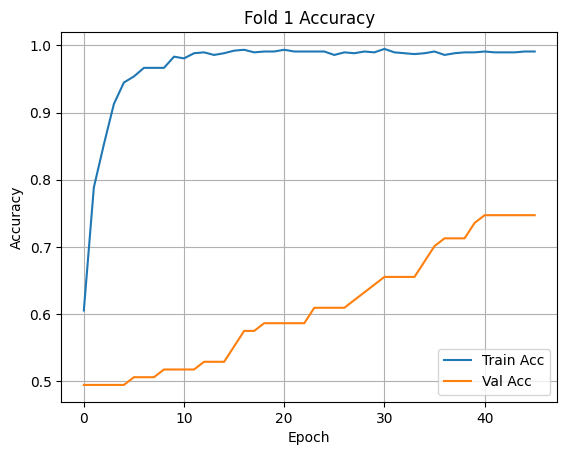

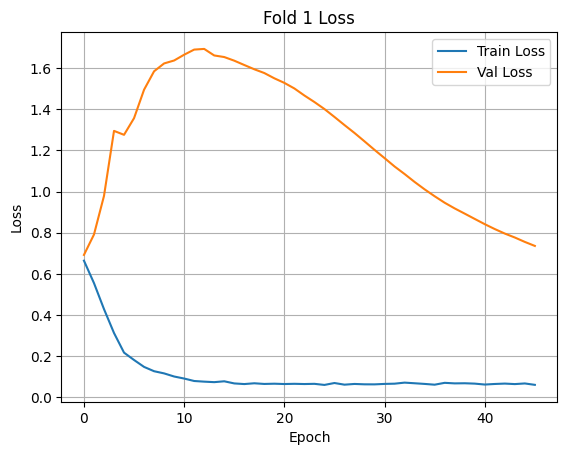

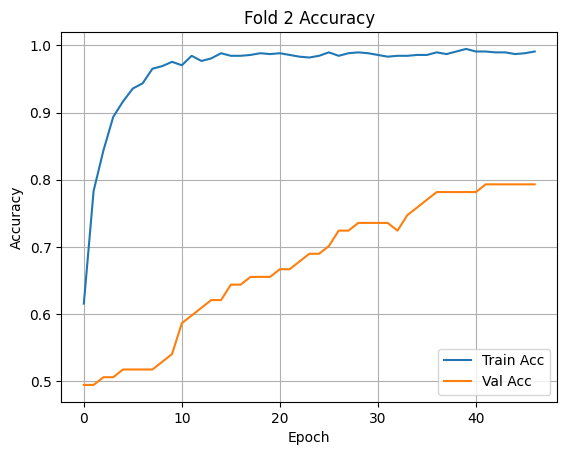

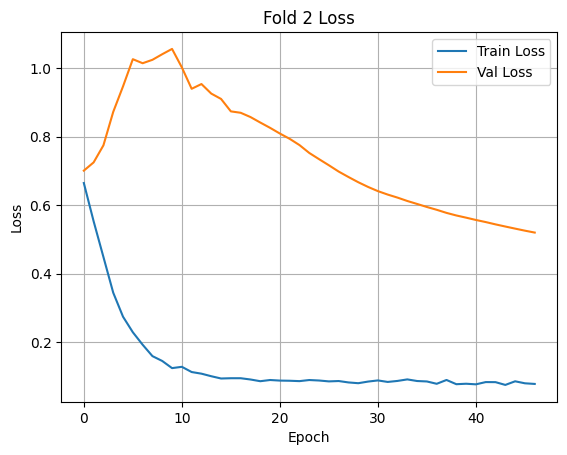

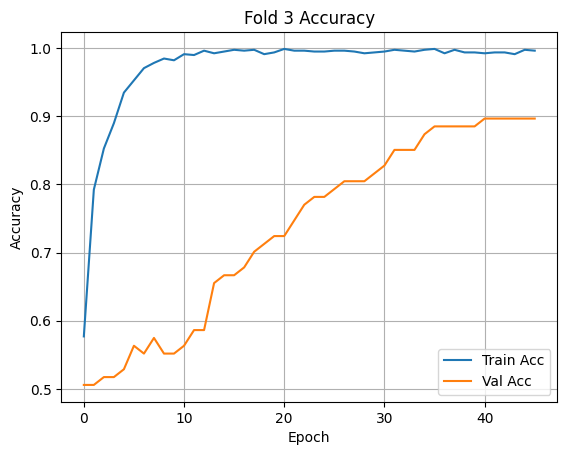

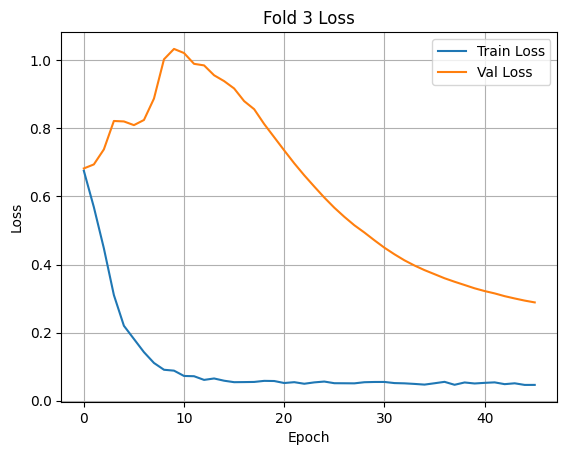

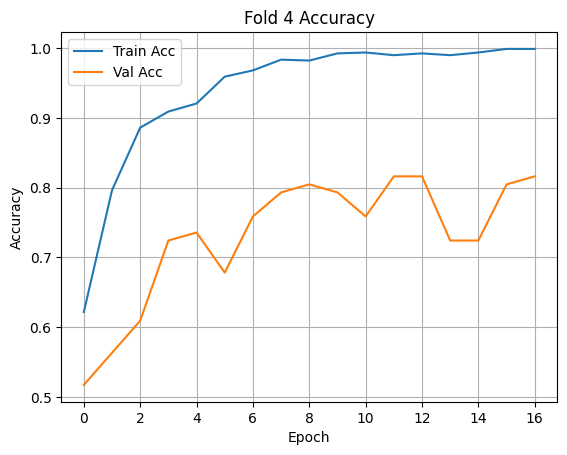

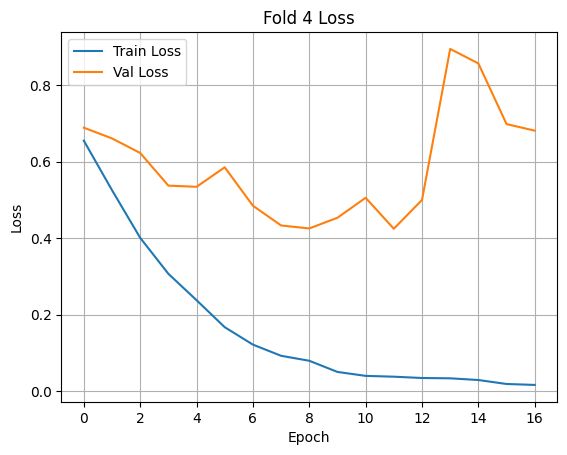

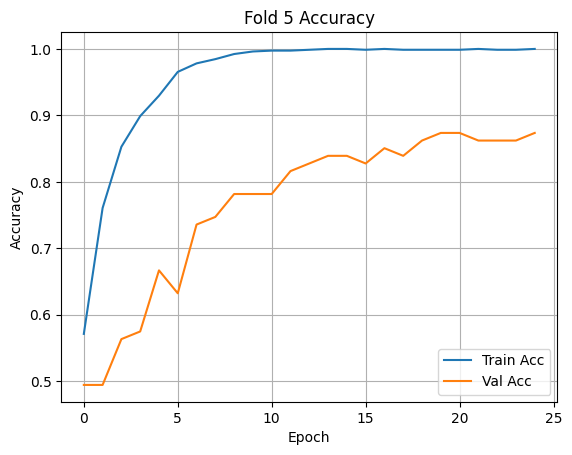

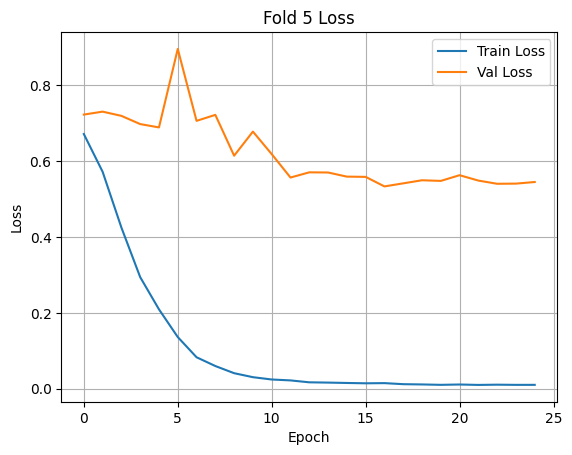

In [10]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
# Save mô hình fold cuối cùng
model.save("mobilenetv2_hmm_faceplus_final.h5")


/home/huuquangdang/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.787899
precision    0.716686
recall       0.654434
f1           0.682856
auc          0.935345
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.880184,0.965909,0.787037,0.867347,0.953449
1,2,0.502304,0.000000,0.000000,0.000000,0.943340
2,3,0.861751,0.915789,0.798165,0.852941,0.936544
3,4,0.824885,0.838095,0.807339,0.822430,0.895260
4,5,0.870370,0.863636,0.879630,0.871560,0.948131


In [13]:
import pandas as pd

# Giả sử results đã có và bạn đã tạo results_df
results_df = pd.DataFrame(results)

# Tính các chỉ số
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()  # dùng sample std (chia cho n-1)
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

# In kết quả
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))

print(f"\n✅ CV Accuracy (Mean Accuracy): {accuracy_mean:.4f}")
print(f"📈 Range Accuracy: {accuracy_range:.4f}")
print(f"📉 Accuracy CV% (std/mean): {accuracy_cv_percent:.2f}%")

# Hiển thị bảng kết quả nếu cần
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.787899
precision    0.716686
recall       0.654434
f1           0.682856
auc          0.935345
dtype: float64

✅ CV Accuracy (Mean Accuracy): 0.7879
📈 Range Accuracy: 0.3779
📉 Accuracy CV% (std/mean): 20.44%


,fold,accuracy,precision,recall,f1,auc
0,1,0.880184,0.965909,0.787037,0.867347,0.953449
1,2,0.502304,0.000000,0.000000,0.000000,0.943340
2,3,0.861751,0.915789,0.798165,0.852941,0.936544
3,4,0.824885,0.838095,0.807339,0.822430,0.895260
4,5,0.870370,0.863636,0.879630,0.871560,0.948131
